## Introduction

The objective of this Jupyter notebook is to compute the electrical conductivity using Ziman’s formula, starting from a spherically symmetric potential V(r)V(r). The conductivity is given by Ziman’s formula:

\begin{equation}
\sigma(\omega) = \frac{\beta}{3\pi^2} \int_{0}^{+\infty} \frac{p^4 \nu_p}{\nu_p^2 + \omega^2} f(1 - f) , dp,
\end{equation}

where νpνp​ is the collision frequency, and ff is the Fermi-Dirac distribution function, given by:

\begin{equation}
f(p) = \frac{1}{1 + e^{\beta(p^2/2 - \mu)}},
\end{equation}

with β=1/(kBT)β=1/(kB​T), and μμ being the chemical potential calculated from the average atom code. The collision frequency is expressed in terms of the phase shifts δl(p)δl​(p) and the ionic density nini​ as follows:

\begin{equation}
\nu_p = \frac{4\pi n_i}{p} \sum_{l=0}^{\infty} (l + 1) \sin^2[\delta_{l+1}(p) - \delta_l(p)].
\end{equation}

To compute the phase shifts, we will solve the Schrödinger equation using a matrix-based method.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.special import spherical_jn, spherical_yn
import time
from scipy import interpolate

In [ ]:
# Mesh parameters
N = 1000
r_min = 0.0
r_max = 10.0
h = (r_max - r_min) / N
r_full = np.linspace(r_min, r_max, N + 1)
r = r_full[1:-1]  # zero on-board conditions
size_r = len(r)

# Definition of over/under diagonal
off_diag = -0.5 / h**2 * np.ones(N - 2)

def spectre_tridiag(V,ell):
    main_diag = 1 / h**2 + ell*(ell + 1) / (2 * r**2) + V
    energies, wavefuncs = eigh_tridiagonal(main_diag, off_diag)
    return energies, wavefuncs

# Validation in the case of zero potential.

Let's assume,

\begin{equation}
V(r) = 0.
\end{equation}

In this case, we know that to within one normalisation constant $A$, the wave functions are of the form,

\begin{equation}
u_l(r) = A prj_l(pr),
\end{equation}

where les $j_l$ are the spherical Bessel functions of the first kind.

In [4]:
V = np.zeros_like(r)

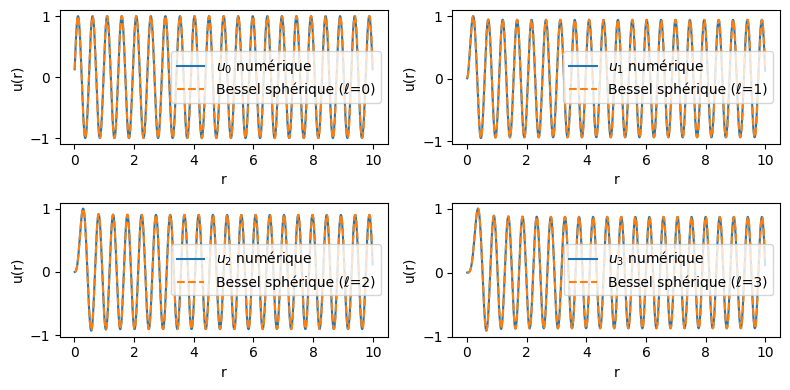

In [5]:
plt.figure(figsize=(8, 4))

n_en = 40  # Energy level index
ell_values = range(4)  # ell = 0 to 3

for i, ell in enumerate(ell_values, 1):
    plt.subplot(2, 2, i)

    en, wf = spectre_tridiag(V, ell)
    p = np.sqrt(2 * en[n_en])
    u_b = p * r * spherical_jn(ell, p * r)

    plt.plot(r, np.sign(wf[0,n_en])*wf[:, n_en] / np.max(np.abs(wf[:, n_en])), label=f"$u_{ell}$ numérique")
    plt.plot(r, np.sign(u_b[0])*u_b / np.max(np.abs(u_b)), '--', label=f"Bessel sphérique (ℓ={ell})")

    plt.xlabel("r")
    plt.ylabel("u(r)")
    plt.legend()
    plt.tight_layout()

plt.show()

# Validation in the case of Yukawa potential

Let's now calculate the $\delta_\ell$ phase shifts with the tridiagonal solver and compare them with those obtained using Calogero's method. For fixed coefficients $a$ and $b$, we take,

\begin{equation}
V(r) = -\frac{ae^{-br}}{r}.
\end{equation}

The phase shifts are calculated by fitting the numerical wave function to a spherical Bessel function for $r \to +\infty$.

We know that the solution to the differential equation $(1)$ is written in $r \to +\infty$ as,

\begin{equation}
u_\ell(r) = Apr [ \cos(\delta_\ell)j_\ell(pr) - \sin(\delta_\ell) n_\ell(pr) ].
\end{equation}

By choosing two points $r_1$ and $r_2$ close to $r_{max}$, for example in the code, $u_\ell[-3]$ and $u_\ell[-2]$, we can express the phase shift as follows,

\begin{equation}
\tan(\delta_\ell) = \frac{r_2 j_\ell(pr_2)u_\ell(r_1) - r_1j_\ell(pr_1)u_\ell(r_2)}{r_2n_\ell(pr_2)u_\ell(r_1) - r_1n_\ell(pr_1)u_\ell(r_2)}.
\end{equation}

In [ ]:
a = 29
b = 8
V = -a*np.exp(-b*r)/r
print('Potential at infinity:', V[-1])

Potentiel à l'infini : -5.675674960792387e-35


In [ ]:
# Phase shift matrix construction
L_max = 6         # \ell max
N_levels = 100     # nombres de points en E
ps_tridiag = np.zeros((L_max, N_levels))
p_tridiag = np.zeros((L_max, N_levels))

# Definition of the grid in p
pmin = 0
pmax = 30
npgrid = 100
pgrid = np.linspace(pmin,pmax,npgrid)

# Calculation of phase shifts
for ell in range(L_max):
    energies, wavefuncs = spectre_tridiag(V, ell)

    for n in range(N_levels):
        E = energies[n]
        if E < 0:
            continue  # ignores linked states

        p = np.sqrt(2 * E)
        u = wavefuncs[:, n]

        # choice of points to extract the phase shift
        r1, r2 = r[-3], r[-2]
        u1, u2 = u[-3], u[-2]

        j1, j2 = spherical_jn(ell, p*r1), spherical_jn(ell, p*r2)
        n1, n2 = spherical_yn(ell, p*r1), spherical_yn(ell, p*r2)

        numer = r2*j2*u1 - r1*j1*u2
        denom = r2*n2*u1 - r1*n1*u2

        ps_temp = np.mod(np.arctan(numer/denom),np.pi)

        ps_tridiag[ell, n] = ps_temp
        p_tridiag[ell, n] = p

The calculated phase shifts have a different energy grid, and therefore a different impulse grid for each $\ell$. We need to interpolate them on the same grid. Before doing this, since the phase shifts are defined modulo $2\pi$, we need to remove the discontinuities. To do this, we define the following function

In [60]:
def unwrap(delta_raw):

    delta_raw = np.asarray(delta_raw)
    delta_unwrapped = np.zeros_like(delta_raw)
    delta_unwrapped[0] = delta_raw[0]

    for i in range(1, len(delta_raw)):
        diff = delta_raw[i] - delta_raw[i - 1]

        # Find the nearest multiple of π that brings the jump closest to zero
        diff_corrected = diff - np.pi * np.round(diff / np.pi)

        # Unwrapped value is previous + corrected diff
        delta_unwrapped[i] = delta_unwrapped[i - 1] + diff_corrected

    return delta_unwrapped

In [61]:
ps_unwrap = np.zeros((L_max, N_levels))
ps_interp = np.zeros((L_max, N_levels))

for i in range(L_max):
    ps_unwrap[i,:] = unwrap(ps_tridiag[i,:])

for i in range(L_max):
    valid = p_tridiag[i, :] > 0
    f = interpolate.interp1d(
        p_tridiag[i, :][valid],
        ps_unwrap[i, :][valid],
        kind='cubic',
        bounds_error=False,
        fill_value=0,
    )
    ps_interp[i, :] = f(pgrid)

## Comparison with Calogero's method

To compare these phase shifts, we integrate them directly, using the Calogero equation,


\begin{equation}
\delta_l'(r) = -\frac{2V(r)}{p}[\cos(\delta_l)j_l(pr)-\sin(\delta_l)n_l(pr)]^2.
\end{equation}

To do this, we use a Runge-Kutta type method, with an adaptive step, called Runge-Kutta-Merson.

In [62]:
def runge_kutta_merson(f, p, l, y0, t0, t_end, h0, tol):
    # Initial conditions
    t = t0
    y = y0
    h = h0

    # Storage for solutions
    t_values = [t]
    y_values = [y]

    while (t_end - t) > 0:
        if t + h > t_end:
            h = t_end - t

        k1 = h * f(t, y, p, l)
        k2 = h * f(t + h / 3, y + k1 / 3, p, l)
        k3 = h * f(t + h / 3, y +  k1 / 6 + k2 / 6, p, l)
        k4 = h * f(t + h / 2, y + k1 / 8 + 3 * k3 / 8, p, l)
        k5 = h * f(t + h, y + k1 / 2 - 3 * k3 / 2 + 2 * k4, p, l)

        y_new = y + (1/6) * (k1 + 4 * k4 + k5)
        y_mid = y + k1/2 -3*k3/2+2*k4

        error = 0.2*np.abs(y_new - y_mid)

        if error > tol:
            h=h/2
        else :
            t = t+h
            y = y_new
            t_values.append(t)
            y_values.append(y)
            if error < tol/64:
                h = 1.9*h
    return np.array(t_values), np.array(y_values)

In [63]:
def v_yukawa(r):
    if r==0:
        return 0
    else:
        return -a*np.exp(-b*r)/r

def f_calogero(r, y, p, l):
    if r==0:
        return 0
    else:
        jl = p*r*spherical_jn(l,p*r, False)
        nl = p*r*spherical_yn(l,p*r, False)
        return (-2*v_yukawa(r)/p)*(np.cos(y)*jl-np.sin(y)*nl)**2

def phase_shift_rkm(l,p,tol):
    t_val_temp, y_val_temp = runge_kutta_merson(f_calogero, p, l, 0, 0, r_max, 1e-10,tol)
    n_temp = np.size(y_val_temp)
    return y_val_temp[n_temp-1]

In [64]:
ps_rkm = np.zeros((L_max,N_levels))

start = time.time()
for i in range(L_max):
    for j in range(0,N_levels):
        if (pgrid[j]==0):
            ps_rkm[i,j]=0
        else:
            ps_rkm[i,j] = phase_shift_rkm(i,pgrid[j],1e-4)
stop = time.time()
print(f"Runge Kutta Merson - exécution en : {stop-start: .2f} secondes.")

Runge Kutta Merson - exécution en :  17.51 secondes.


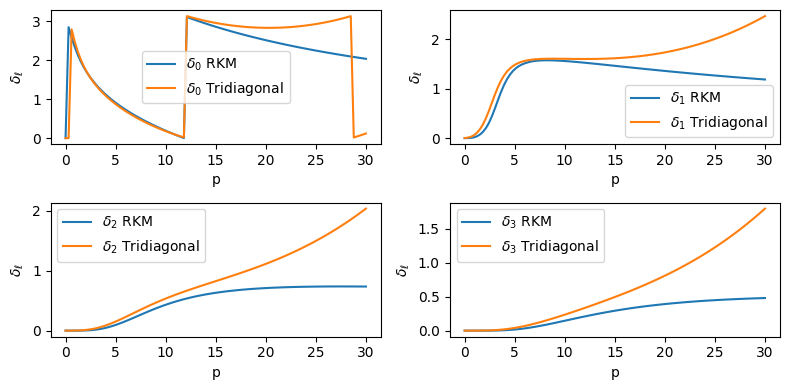

In [65]:
plt.figure(figsize=(8, 4))
for i, ell in enumerate(ell_values, 1):
    plt.subplot(2, 2, i)

    plt.plot(pgrid, np.mod(ps_rkm[ell, :],np.pi), label=f"$\delta_{ell}$ RKM")
    plt.plot(pgrid, ps_tridiag[ell, :],label=f"$\delta_{ell}$ Tridiagonal")

    plt.xlabel("p")
    plt.ylabel("$\delta_\ell$")
    plt.legend()
    plt.tight_layout()

plt.show()

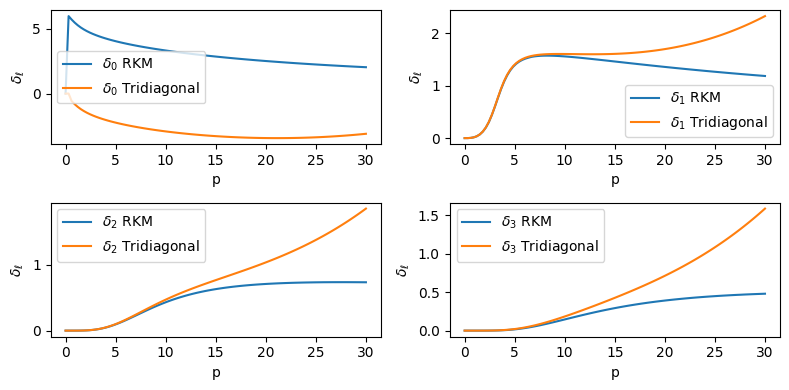

In [66]:
plt.figure(figsize=(8, 4))
for i, ell in enumerate(ell_values, 1):
    plt.subplot(2, 2, i)

    plt.plot(pgrid, ps_rkm[ell, :], label=f"$\delta_{ell}$ RKM")
    plt.plot(pgrid, ps_interp[ell, :],label=f"$\delta_{ell}$ Tridiagonal")

    plt.xlabel("p")
    plt.ylabel("$\delta_\ell$")
    plt.legend()
    plt.tight_layout()

plt.show()

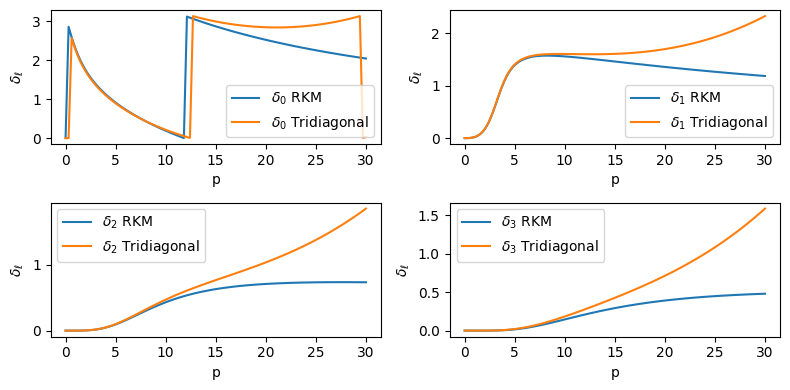

In [67]:
plt.figure(figsize=(8, 4))
for i, ell in enumerate(ell_values, 1):
    plt.subplot(2, 2, i)

    plt.plot(pgrid, np.mod(ps_rkm[ell, :],np.pi), label=f"$\delta_{ell}$ RKM")
    plt.plot(pgrid, np.mod(ps_interp[ell, :],np.pi),label=f"$\delta_{ell}$ Tridiagonal")

    plt.xlabel("p")
    plt.ylabel("$\delta_\ell$")
    plt.legend()
    plt.tight_layout()

plt.show()

# Calculating electrical conductivity

In [ ]:
# Parameters
om_el = 1
beta_el = 1
mu_el = 1
conversion_sigma = 1

# Definition of the Fermi-Dirac function
def fd_el_p(p):
    return 1/(1+np.exp(beta_el*(p**2/2-mu_el)))

In [69]:
omega_grid = np.linspace(0,100,1000)

def sigma(omega,tableau):
    prefacteur = beta_el/(3*np.pi**2)
    int_temp = 0
    dp = pmax/npgrid

    for i in range(2,N_levels):
        somme = np.sum(np.arange(1,L_max)*np.sin(tableau[1:,i]-tableau[:-1,i])**2)
        nu_dephasage = (4*np.pi/(pgrid[i]*om_el))*somme
        if (beta_el*(pgrid[i]**2/2-mu_el)>100):
            f_occ = 0
        else :
            f_occ = fd_el_p(pgrid[i])*(1-fd_el_p(pgrid[i]))
        int_temp += (pgrid[i])**4*nu_dephasage*f_occ/(nu_dephasage**2+omega**2)

    return conversion_sigma*prefacteur*int_temp*dp

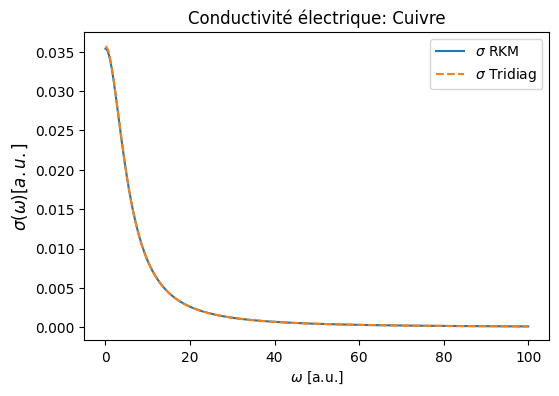

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(omega_grid,sigma(omega_grid,ps_rkm), label='$\sigma$ RKM')
plt.plot(omega_grid,sigma(omega_grid,ps_interp), '--', label='$\sigma$ Tridiag')
plt.title('Electrical conductivity: Cuivre')
plt.xlabel('$\omega$ [a.u.]', fontsize=10)
plt.ylabel(r'$\sigma(\omega) [a.u.]$', fontsize=12);
plt.legend()
plt.show()